***Setting The Environment***

In [ ]:
%tensorflow_version 1.x

In [ ]:
!pip install tensorflow-object-detection-api

***Loading the Model***

In [ ]:
 import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import math
import cv2

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
import itertools
from itertools import compress

from IPython.display import display

sys.path.append("..")
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

import time



### Model preparation variable
# Model frozen Inference Graph 
PATH_TO_FROZEN_GRAPH ='/content/drive/My Drive/evaluation/pretrainedmodel/ssd_mobilenet_v1_0.75_depth/frozen_inference_graph.pb'
#Label File
PATH_TO_LABELS ='/content/drive/My Drive/model2/data/labelmap.pbtxt'
NUM_CLASSES =1 


### Load a (frozen) Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')


###Loading label map
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)




### Load image into numpy function
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)




###STATING THE PATH TO IMAGES TO BE TESTED
PATH_TO_TEST_IMAGES_DIR = '/content/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}.jpg'.format(i)) for i in ['tt'] ]
IMAGE_SIZE = (12, 8)



### Function to run inference on a single image which will later be used in an iteration
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict


**Functions Required For Calculating Distance**

In [ ]:
 

def cal_dis(p1, p2, distance_w, distance_h):   
    h = abs(p2[1]-p1[1])
    w = abs(p2[0]-p1[0]) 
    dis_w = float((w/distance_w)*490)
    dis_h = float((h/distance_h)*330)
    return int(np.sqrt(((dis_h)**2) + ((dis_w)**2)))

def calculate_points(bounding_box,w,h):
  x=int(((bounding_box[3]-bounding_box[1])/2+bounding_box[1])*w)
  y=int(bounding_box[2]*h)
  return (x,y)

def transform_pts(point,prespective_transform):
  pts = np.float32([[point[0],point[1]]])
  pts=np.array([pts])
  bd_pnt = cv2.perspectiveTransform(pts, prespective_transform)[0][0]
  return (int(bd_pnt[0]),int(bd_pnt[1]))

def get_distances(detection_boxes,detection_points,detection_transformed_pts,distance_w, distance_h):

    pnts = []
    box=[]  

    for i in range(len(detection_transformed_pts)):
        for j in range(len(detection_transformed_pts)):
            if i != j:
                dist = cal_dis(detection_transformed_pts[i], detection_transformed_pts[j], distance_w, distance_h)
                if dist <=200:
                    pnts.append((detection_points[i], detection_points[j]))
                    box.append(detection_boxes[i])
                    box.append(detection_boxes[j])          
    return pnts,box


def get_normalized_boxes(bounding_box,w,h):
    ymin=int(bounding_box[0]*h)
    xmin=int(bounding_box[1]*w)
    ymax=int(bounding_box[2]*h)
    xmax=int(bounding_box[3]*w)
    return((xmin,xmax,ymin,ymax))



In [ ]:


def show_inference(image_path):
  
  person_class = 1
  score_treshold = 0.5
  image = Image.open(image_path)
  image_np = load_image_into_numpy_array(image)
  image_np_expanded = np.expand_dims(image_np, axis=0)
  #getting the detections
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)

  #4 points selection and calculation of transformation matrix
  src = np.float32([[185, 667], [1621,904], [2374,141], [1565, 46]])
  dst = np.float32([[0,2684], [1510,2684], [1510, 0], [0, 0]])
  prespective_transform = cv2.getPerspectiveTransform(src, dst)

  #real world distance conversion
  pts = np.float32([[1261,495], [1922,597], [889,600], [1175,431]])
  pts=np.array([pts])
  warped_pt = cv2.perspectiveTransform(pts, prespective_transform)[0] 
  distance_w = np.sqrt((warped_pt[0][0] - warped_pt[1][0]) ** 2 + (warped_pt[0][1] - warped_pt[1][1]) ** 2)
  distance_h = np.sqrt((warped_pt[2][0] - warped_pt[3][0]) ** 2 + (warped_pt[2][1] - warped_pt[3][1]) ** 2)

  #Filter persons and boxes with a score higher than 50% and drawing all boxes
  boolPersons = output_dict['detection_classes'] == person_class
  boolScores = output_dict['detection_scores'] > score_treshold
  boolCombined = np.logical_and(boolPersons,boolScores)

  output_dict['detection_scores'] = output_dict['detection_scores'][boolCombined]
  output_dict['detection_classes'] = output_dict['detection_classes'][boolCombined]
  output_dict['detection_boxes'] = output_dict['detection_boxes'][boolCombined]
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=2,
      min_score_thresh=score_treshold)
  
  #image width and size for normalization 
  im = Image.fromarray(image_np)
  w,h= im.size
  #get the bottom centre point of each box and then transform it
  output_dict['detection_points'] = [calculate_points(x,w,h) for x in output_dict['detection_boxes']]
  output_dict['detection_transformed_pts']=[transform_pts(x,prespective_transform) for x in output_dict['detection_points']]

  #calculting distance and then saving the box and points for people who broke social distancing
  output_dict['detection_permutations'],output_dict['detection_boxes'] =get_distances(output_dict['detection_boxes'],output_dict['detection_points'],output_dict['detection_transformed_pts'],distance_w, distance_h)
  output_dict['detection_boxes']=[get_normalized_boxes(x,w,h) for x in output_dict['detection_boxes']]
  #draw red boxes and crop images
  draw2 = ImageDraw.Draw(im)
  for box in output_dict['detection_boxes']: 
    xmin=box[0]
    xmax=box[1]
    ymin=box[2]
    ymax=box[3]
    im1 = im.crop((xmin, ymin, xmax, ymax))
    im1=im1.save('frame_'+str(xmin)+'.jpg')
    draw2.line([(xmin,ymin), (xmin, ymax), (xmax, ymax), (xmax,ymin),(xmin,ymin)],
              width=4,
              fill=255)


  #draw lines
  draw = ImageDraw.Draw(im)
  for point in output_dict['detection_permutations']: 
     draw.line((point[0],point[1]), fill=255, width=2)
  
  
   #uncomment the below lines for video and comment the display line 
  #im_np = load_image_into_numpy_array(im)
  #return(im_np)
  display(im)

**Running inference on images**

2.2584283351898193


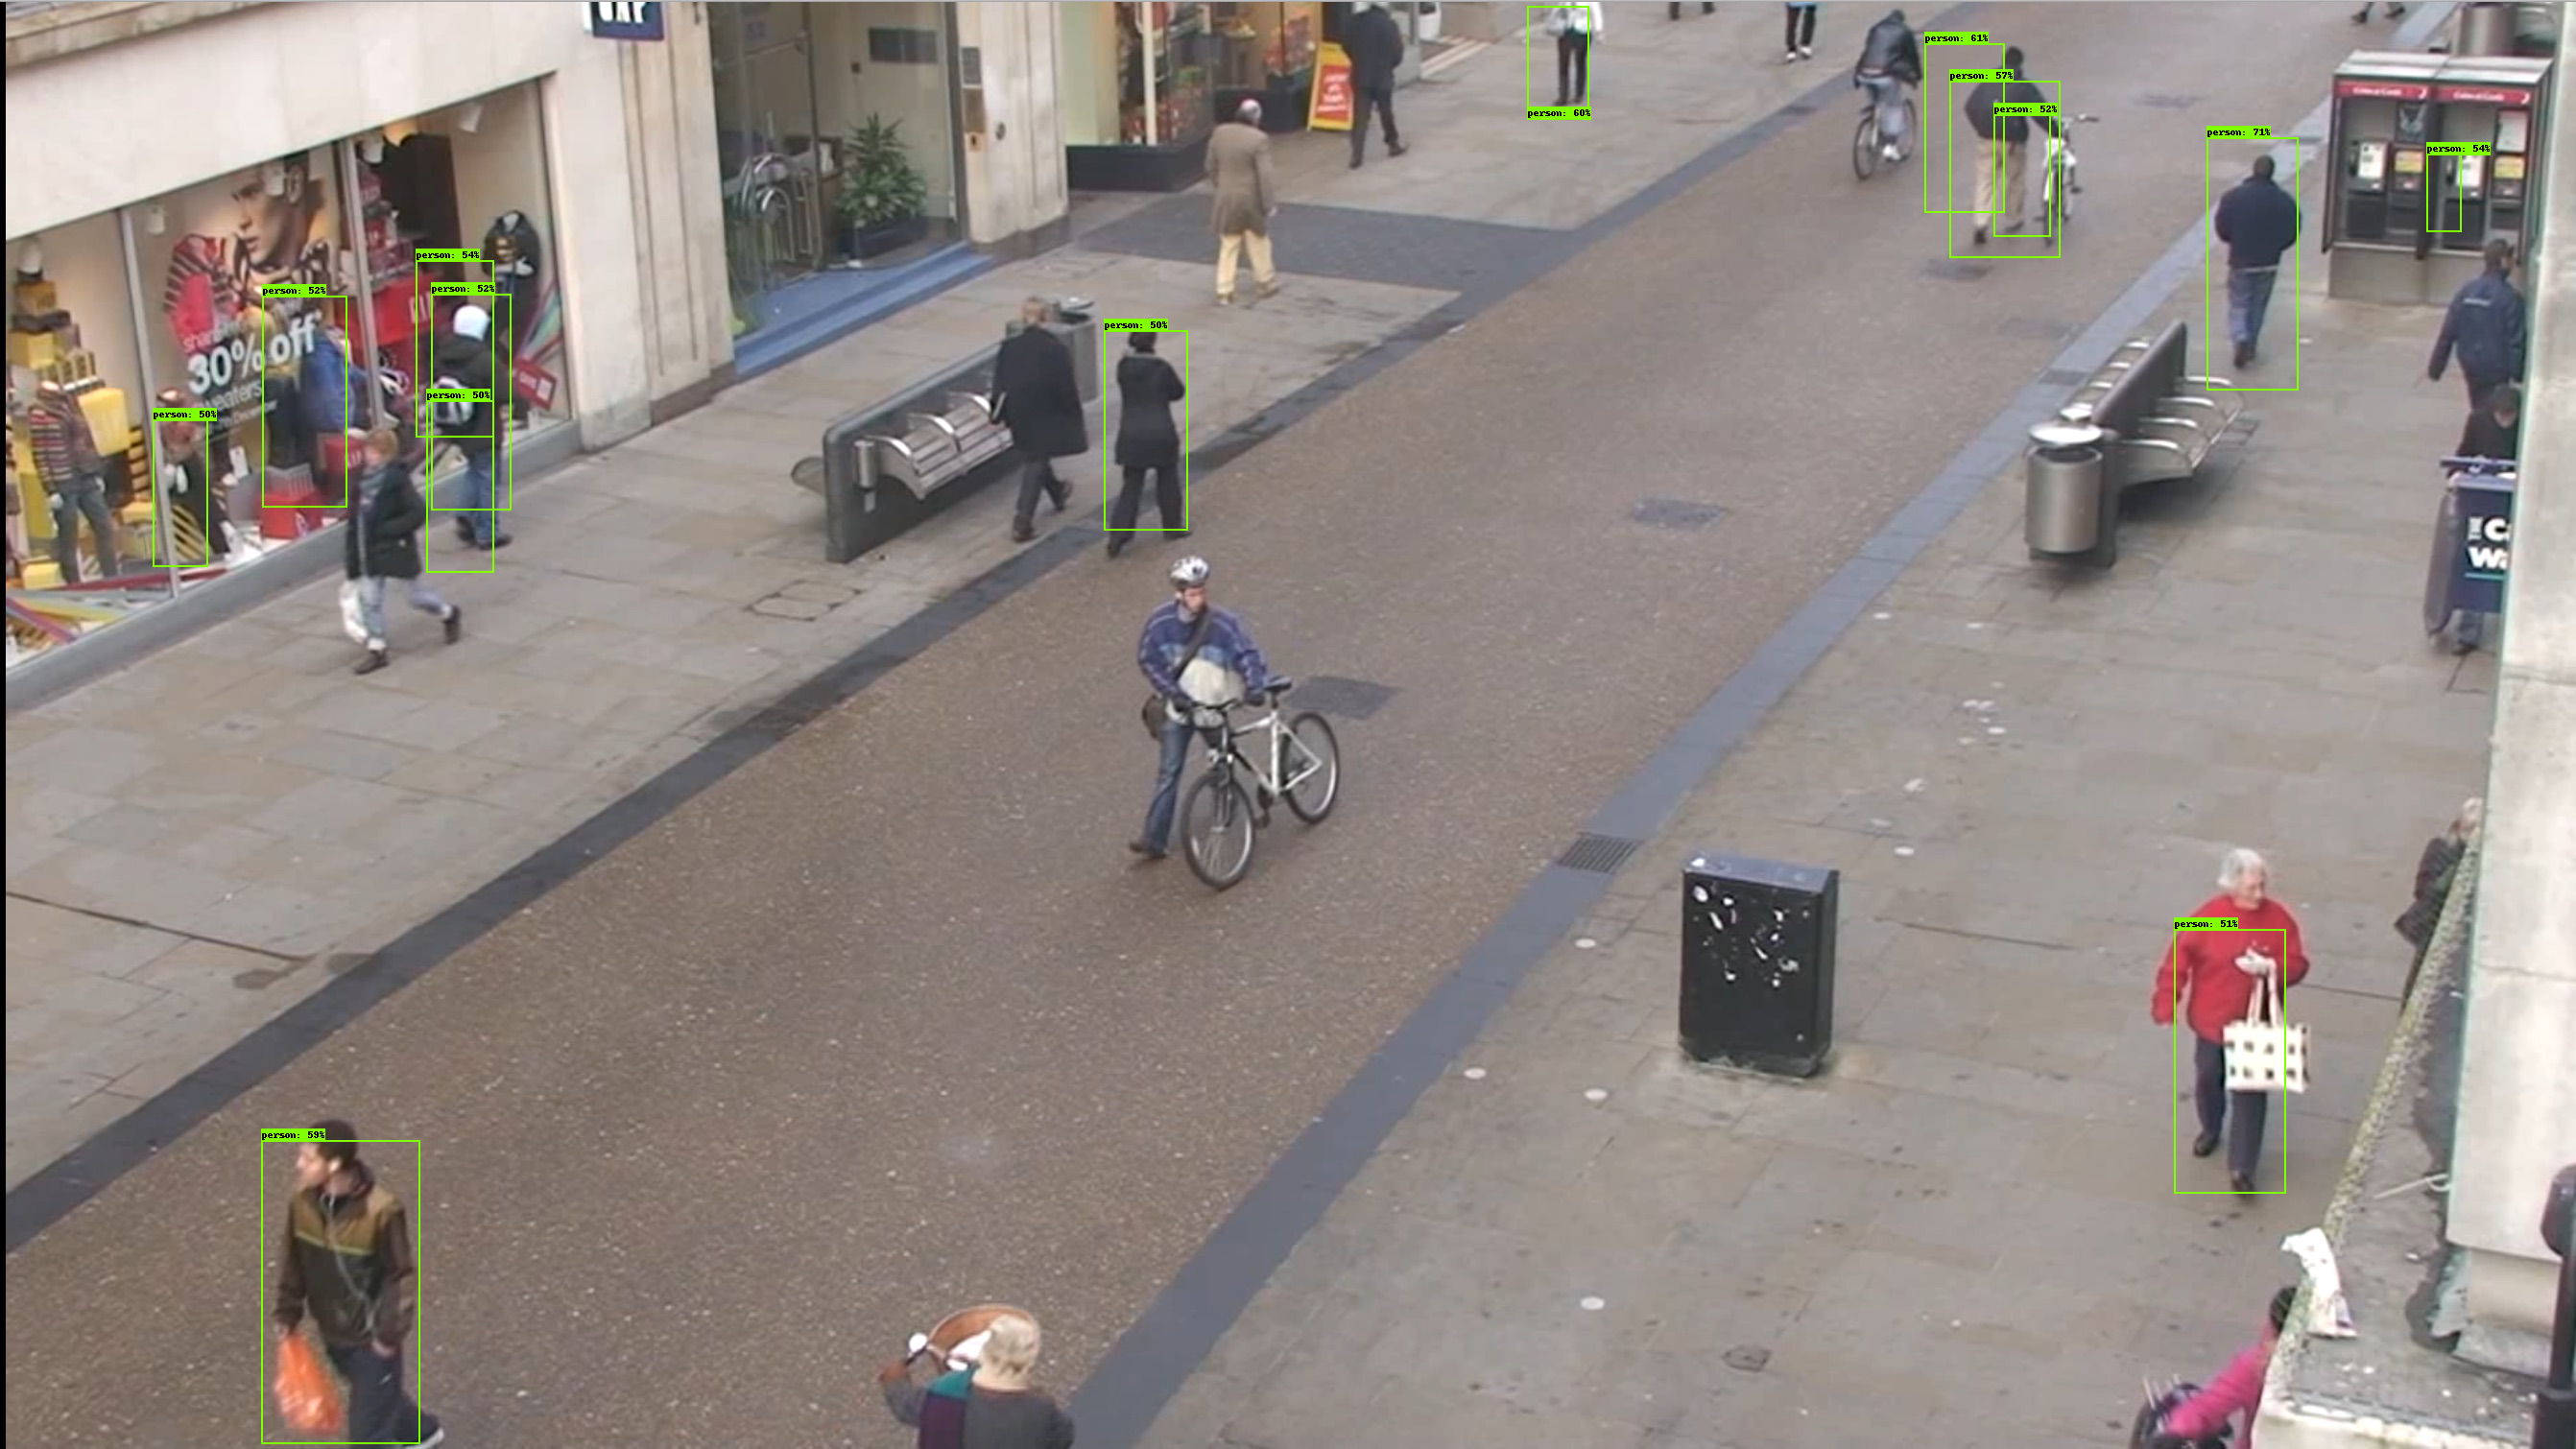

7.206568717956543


'\n#code for making a video\n\n%cd \'/content/drive/My Drive\'\nfrom moviepy.editor import VideoFileClip\nwrite_output = \'output_video_another.mp4\'\nclip1 = VideoFileClip("video_1.mp4")\nwhite_clip = clip1.fl_image(show_inference)\n%time white_clip.write_videofile(write_output, audio=False)\n'

In [ ]:

for image_path in TEST_IMAGE_PATHS:
  show_inference(image_path)

'''
#code for making a video

%cd '/content/drive/My Drive'
from moviepy.editor import VideoFileClip
write_output = 'output_video_another.mp4'
clip1 = VideoFileClip("video_1.mp4")
white_clip = clip1.fl_image(show_inference)
%time white_clip.write_videofile(write_output, audio=False)
'''